In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import data_cleaner as dc
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
import importlib
importlib.reload(dc)
%matplotlib inline

In [85]:
df = pd.read_csv('data/df.csv', index_col=0).dropna()
df.columns = df.columns.str.lower()
df = df.rename(columns={'addr_pct_cd' : 'pct'})
df['policy'] = (df.year < 2013).mul(1)
df['nonstop_arrests'] = df.arrests - df.stop_arrests
df['crimerate'] = df.cmplnts / df.population * 1000
df['nonstop_arrestrate'] = df.nonstop_arrests / df.population * 1000
df['stoprate'] = df.stops / df.population * 1000
df['stop_arrestrate'] = df.stop_arrests / df.population * 1000

In [86]:
df

,year,pct,cmplnts,population,arrests,stops,stop_arrests,policy,nonstop_arrests,crimerate,nonstop_arrestrate,stoprate,stop_arrestrate
2,2008.0,1.0,6614.0,66679.0,5008.0,2506.0,221.0,1,4787.0,99.191650,71.791719,37.583047,3.314387
3,2009.0,1.0,6280.0,66679.0,5371.0,2585.0,238.0,1,5133.0,94.182576,76.980759,38.767828,3.569340
4,2010.0,1.0,5895.0,66679.0,4950.0,2446.0,260.0,1,4690.0,88.408644,70.336988,36.683214,3.899279
5,2011.0,1.0,5955.0,66679.0,5583.0,3626.0,215.0,1,5368.0,89.308478,80.505107,54.379940,3.224403
6,2012.0,1.0,6287.0,66679.0,5479.0,3053.0,189.0,1,5290.0,94.287557,79.335323,45.786529,2.834476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2014.0,123.0,2859.0,98032.0,1555.0,321.0,70.0,0,1485.0,29.163946,15.148115,3.274441,0.714053
984,2015.0,123.0,2732.0,98032.0,1439.0,127.0,30.0,0,1409.0,27.868451,14.372858,1.295495,0.306023
985,2016.0,123.0,2648.0,98032.0,1568.0,90.0,32.0,0,1536.0,27.011588,15.668353,0.918068,0.326424
986,2017.0,123.0,2549.0,98032.0,1602.0,62.0,23.0,0,1579.0,26.001714,16.106985,0.632447,0.234617


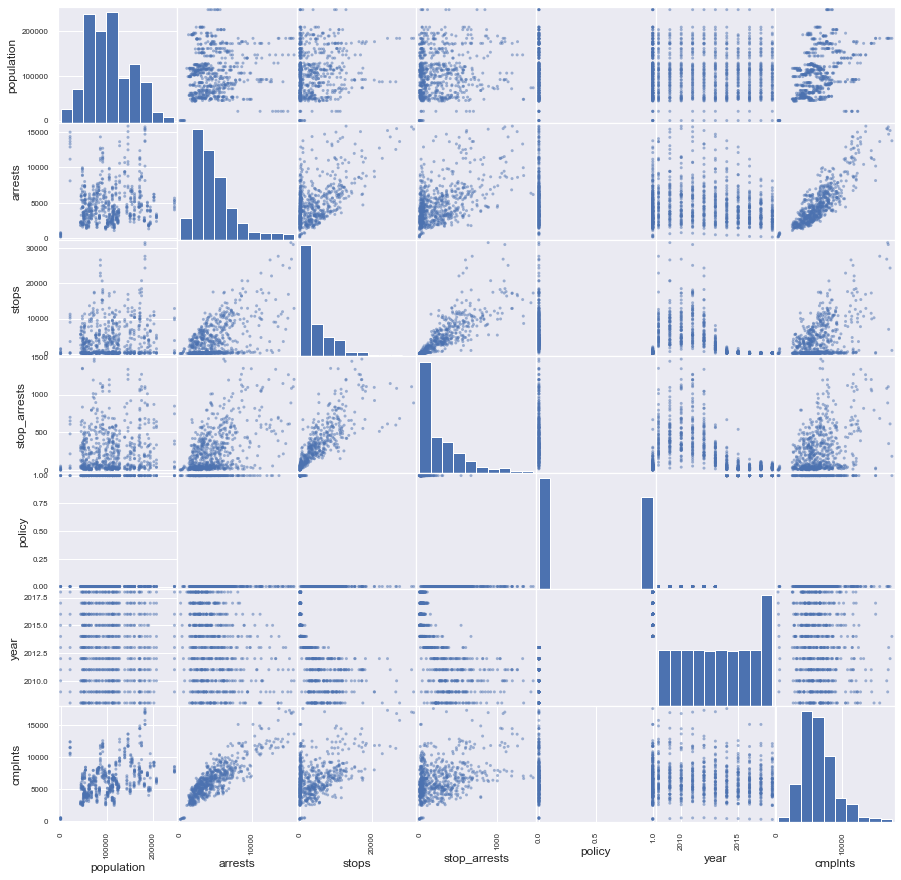

In [64]:
sns.set(rc={'figure.figsize':(15,15)})
pd.plotting.scatter_matrix(train);


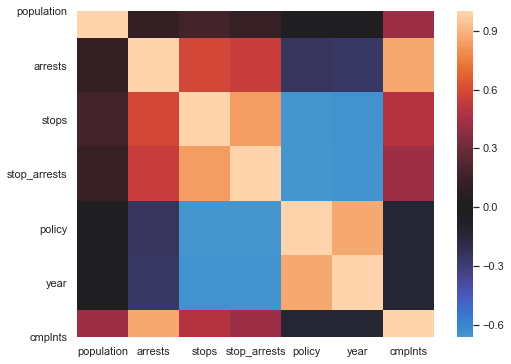

In [71]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(train.corr(), center=0);

## Basic linear model

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [89]:
x_vars = ['population', 'arrests', 'stops', 'stop_arrests', 'policy', 'year']

In [92]:
from statsmodels.formula.api import ols

def run_ols(data, x_vars, y_var):
    y = data[y_var]
    X = data[x_vars]
    formula = f'{y_var} ~ {"+".join(x_vars)}'
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    stratify = df.year.values, \
                                                    test_size = 0.2, \
                                                    random_state = 120219)
    train = X_train.join(y_train)
    lr = ols(formula=formula, data=train)
    rslt = lr.fit()
    return rslt.summary()
run_ols(df, x_vars, 'cmplnts')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cmplnts   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     749.8
Date:                Tue, 03 Dec 2019   Prob (F-statistic):          4.66e-291
Time:                        17:36:51   Log-Likelihood:                -5547.1
No. Observations:                 668   AIC:                         1.111e+04
Df Residuals:                     661   BIC:                         1.114e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.507e+05   4.91e+04     -5.110      0.000   -3.47e+05   -1.54e+05
population       0.0183      0.001     23.249      0.000       0.017       0.020
arrests          0.8352      0.018     46.939      0.000       0.800       0.870
stops           -0.0062      0.016     -0.389      0.697      -0.037       0.025
stop_arrests    -0.7717      0.256     -3.009      0.003      -1.275      -0.268
policy         610.0072    179.152      3.405      0.001     258.232     961.783
year           124.7570     24.337      5.126      0.000      76.970     172.544
==============================================================================
Omnibus:                       14.098   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.601
Skew:                           0.204   Prob(JB):                     5.54e-05
Kurtosis:                       3.733   Cond. No.                     1.52e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [93]:
x_vars = ['nonstop_arrestrate', 'stoprate', 'stop_arrestrate','policy', 'year']
run_ols(df, x_vars, 'crimerate')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              crimerate   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     3738.
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        17:38:04   Log-Likelihood:                -4894.7
No. Observations:                 668   AIC:                             9801.
Df Residuals:                     662   BIC:                             9828.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4.118e+04   1.83e+04     -2.255      0.024    -7.7e+04   -5322.591
nonstop_arrestrate     1.0150      0.017     61.252      0.000       0.982       1.048
stoprate              -0.2371      0.025     -9.415      0.000      -0.287      -0.188
stop_arrestrate        2.4613      0.836      2.944      0.003       0.820       4.103
policy                77.1374     57.771      1.335      0.182     -36.299     190.574
year                  20.4573      9.061      2.258      0.024       2.665      38.250
==============================================================================
Omnibus:                      604.651   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           482746.853
Skew:                           2.864   Prob(JB):                         0.00
Kurtosis:                     134.573   Cond. No.                     4.87e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Try interaction terms

In [26]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
poly.fit_transform(X)
clf = linear_model.LinearRegression()
clf.fit(X, y)

,year,pct,cmplnts,population,arrests,stops,stop_arrests
2,2008.0,1.0,6614.0,66679.0,5008.0,2506.0,221.0
3,2009.0,1.0,6280.0,66679.0,5371.0,2585.0,238.0
4,2010.0,1.0,5895.0,66679.0,4950.0,2446.0,260.0
5,2011.0,1.0,5955.0,66679.0,5583.0,3626.0,215.0
6,2012.0,1.0,6287.0,66679.0,5479.0,3053.0,189.0
...,...,...,...,...,...,...,...
983,2014.0,123.0,2859.0,98032.0,1555.0,321.0,70.0
984,2015.0,123.0,2732.0,98032.0,1439.0,127.0,30.0
985,2016.0,123.0,2648.0,98032.0,1568.0,90.0,32.0
986,2017.0,123.0,2549.0,98032.0,1602.0,62.0,23.0
